In [28]:
#!pip install tensorflow

# Import Necessary Libraries

In [29]:
import pyautogui
from PIL import Image

import cv2
import numpy as np
from PIL import Image
import io
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Define Helper Functions

## acquire_image(): Capture a screenshot of the Sudoku puzzle.

In [30]:
def acquire_image():
    """
    Capture the current screen and return it as an image.

    Returns:
        screenshot (PIL.Image.Image): The captured screenshot.
    """
    # Using pyautogui's screenshot feature to capture the screen
    screenshot = pyautogui.screenshot()
    return screenshot

In [31]:
def visualize_image(image, title="Image"):
    """
    Visualize an image using matplotlib.
    
    Parameters:
        image (PIL.Image.Image or numpy.ndarray): The image to visualize.
        title (str): The title of the visualization.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

## preprocess_image(image): Apply preprocessing steps to prepare the image for grid detection.

In [60]:
def preprocess_image(image):
    """
    Apply preprocessing steps to invert the image colors and make it similar to MNIST format.
    
    Parameters:
        image (PIL.Image.Image): The input image to preprocess.
    
    Returns:
        preprocessed_image (numpy.ndarray): The preprocessed image ready for further analysis.
    """
    # Convert the PIL Image to an OpenCV image (PIL uses RGB, OpenCV uses BGR)
    open_cv_image = np.array(image)
    # Convert RGB to BGR 
    open_cv_image = open_cv_image[:, :, ::-1].copy()
    
    # Convert to grayscale
    gray_image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur to smooth out the image
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
    # Apply adaptive thresholding to create a binary image
    # This step inverts the image: background becomes black, digits become white
    threshold_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                            cv2.THRESH_BINARY_INV, 11, 2)
    
    # No need for edge detection, as we want to keep the digits filled
    
    return threshold_image


## detect_sudoku_grid(preprocessed_image): Detect the grid and segment it into individual cells.

In [33]:
def detect_sudoku_grid(preprocessed_image):
    """
    Detect the Sudoku grid and divide it into 9x9 cells.
    
    Parameters:
        preprocessed_image (numpy.ndarray): The preprocessed image of the Sudoku puzzle.
        
    Returns:
        cells (list of numpy.ndarray): List of 9x9 cell images of the Sudoku grid.
    """
    # Step 1: Find contours
    contours, _ = cv2.findContours(preprocessed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assume the largest contour is the Sudoku grid
    max_area = 0
    sudoku_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            sudoku_contour = contour
    
    if sudoku_contour is None:
        print("Sudoku grid not found")
        return None
    
    # Step 2: Apply perspective transform to get a top-down view of the Sudoku grid
    # Find the corners of the grid
    peri = cv2.arcLength(sudoku_contour, True)
    approx = cv2.approxPolyDP(sudoku_contour, 0.02 * peri, True)
    
    if len(approx) != 4:
        print("Could not find corners of the grid")
        return None
    
    # Order the corners
    ordered_corners = order_points(np.squeeze(approx))
    
    # The maximum width and height of the grid
    side = max([
        np.linalg.norm(ordered_corners[0] - ordered_corners[1]),
        np.linalg.norm(ordered_corners[1] - ordered_corners[2]),
        np.linalg.norm(ordered_corners[2] - ordered_corners[3]),
        np.linalg.norm(ordered_corners[3] - ordered_corners[0])
    ])
    
    # Destination points for the perspective transform
    dst = np.array([
        [0, 0],
        [side - 1, 0],
        [side - 1, side - 1],
        [0, side - 1]], dtype="float32")
    
    # Apply perspective transform
    M = cv2.getPerspectiveTransform(ordered_corners, dst)
    warped = cv2.warpPerspective(preprocessed_image, M, (int(side), int(side)))
    
    # Step 3: Divide the warped image into 9x9 cells
    cells = []
    cell_size = side / 9
    for i in range(9):
        row = []
        for j in range(9):
            start_x = int(j * cell_size)
            start_y = int(i * cell_size)
            cell = warped[start_y:start_y + int(cell_size), start_x:start_x + int(cell_size)]
            row.append(cell)
        cells.append(row)
    
    return cells

In [34]:
def order_points(pts):
    """
    Order the points in clockwise order starting from the top-left point.
    """
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

## preprocess_for_mnist(cell): Preprocess a cell image for MNIST model compatibility.

In [35]:
def preprocess_for_mnist(cell):
    # Resize to 28x28, the size used by MNIST
    resized = cv2.resize(cell, (28, 28), interpolation=cv2.INTER_AREA)
    # Convert to grayscale
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY) if len(resized.shape) == 3 else resized
    # Scale pixel values to 0-1
    scaled = gray / 255.0
    # Expand dimensions to match the input shape for the CNN (1x28x28x1)
    expanded = np.expand_dims(scaled, axis=-1)
    return np.expand_dims(expanded, axis=0)  # Add batch dimension

In [56]:
def visualize_cells_grid_for_mnist(cells, model_preprocess_func):
    """
    Visualize a 9x9 grid of Sudoku cell images after preprocessing them for MNIST.
    
    Parameters:
        cells (list of list of numpy.ndarray): The 9x9 grid of cell images.
        model_preprocess_func (function): The preprocessing function to apply to each cell.
    """
    # Initialize a 9x9 grid of subplots
    fig, axs = plt.subplots(9, 9, figsize=(9, 9))
    fig.suptitle("Cells Preprocessed for MNIST", fontsize=16)
    
    for i in range(9):
        for j in range(9):
            # Preprocess the cell for MNIST but remove the last dimension expansion to visualize it
            preprocessed_cell = model_preprocess_func(cells[i][j])[0].squeeze()
            # Ensure we still have a 2D array after squeezing. If not, it's likely a grayscale image.
            if preprocessed_cell.ndim == 2:
                axs[i, j].imshow(preprocessed_cell, cmap='gray')
            else:
                axs[i, j].imshow(preprocessed_cell)
            axs[i, j].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## recognize digit(s)

In [36]:
def recognize_digit(cell, model):
    preprocessed = preprocess_for_mnist(cell)
    prediction = model.predict(preprocessed)
    return np.argmax(prediction)  # Return the digit with the highest probability

In [37]:
def recognize_digits(cells, model):
    sudoku_matrix = [[0 for _ in range(9)] for _ in range(9)]
    
    for i, row in enumerate(cells):
        for j, cell in enumerate(row):
            # Assuming a simple threshold to identify empty cells
            if np.mean(cell) > 127:
                sudoku_matrix[i][j] = 0
            else:
                sudoku_matrix[i][j] = recognize_digit(cell, model) 
            
    return sudoku_matrix

In [38]:
## Solve Sudoku

In [39]:
## Output Result

# Main

In [64]:
def main():
    # Step 1: Capture the Sudoku puzzle screenshot
    screenshot = acquire_image()
    visualize_image(screenshot, "Original Screenshot")

    # Step 2: Preprocess the image to facilitate grid detection
    preprocessed_image = preprocess_image(screenshot)
    visualize_image(preprocessed_image, "Preprocessed Image")

    # Step 3: Detect the Sudoku grid and extract individual cells
    cells = detect_sudoku_grid(preprocessed_image)
    
    # Step 4: Visualize preprocessed & preprocessed for mnist cells
    if cells:
        visualize_cells_grid(cells, "Extracted Cells")
        visualize_cells_grid_for_mnist(cells, preprocess_for_mnist)
    else:
        print("Failed to detect Sudoku grid or extract cells.")
        return
    
    # Path to the pre-trained digit recognition model
    model_path = 'my_mnist_model.keras'
    
    # Load the pre-trained digit recognition model
    model = load_model(model_path)
    
    # Recognize digits within each cell to populate the Sudoku matrix
    sudoku_matrix = recognize_digits(cells, model)

    print (sudoku_matrix)

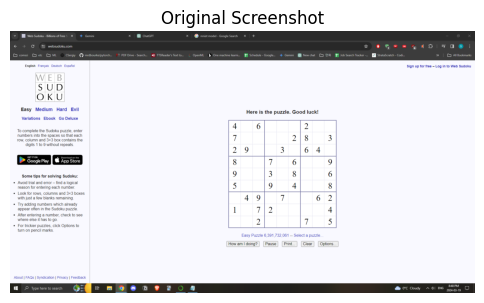

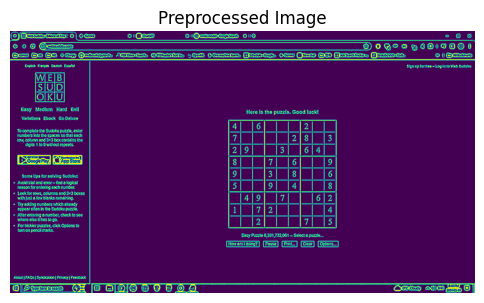

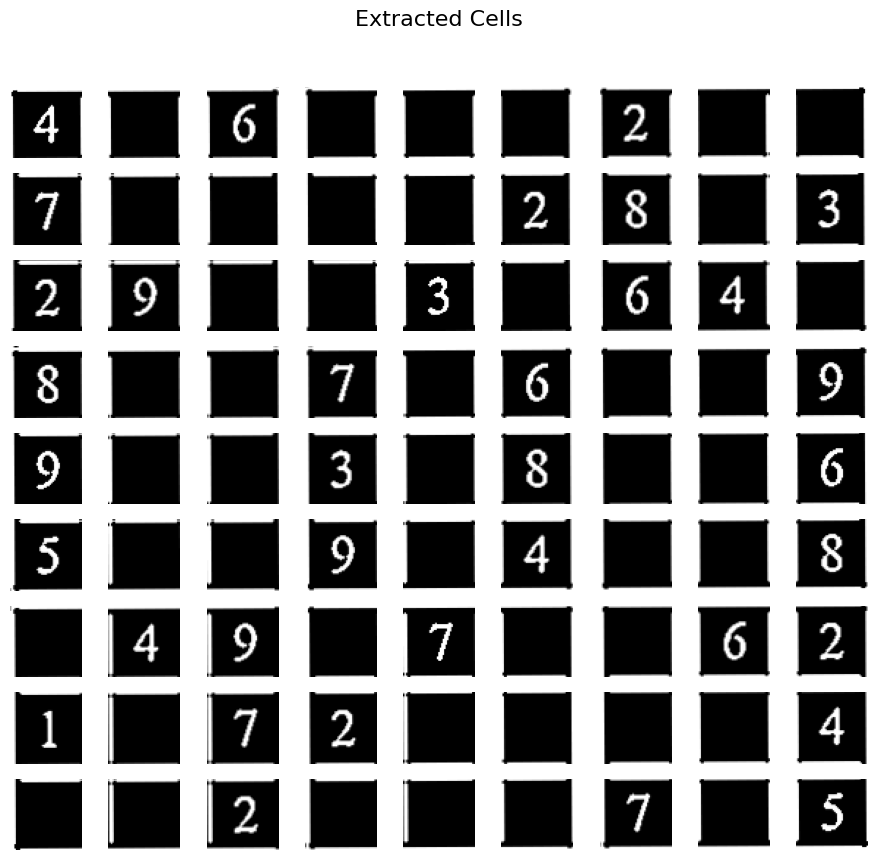

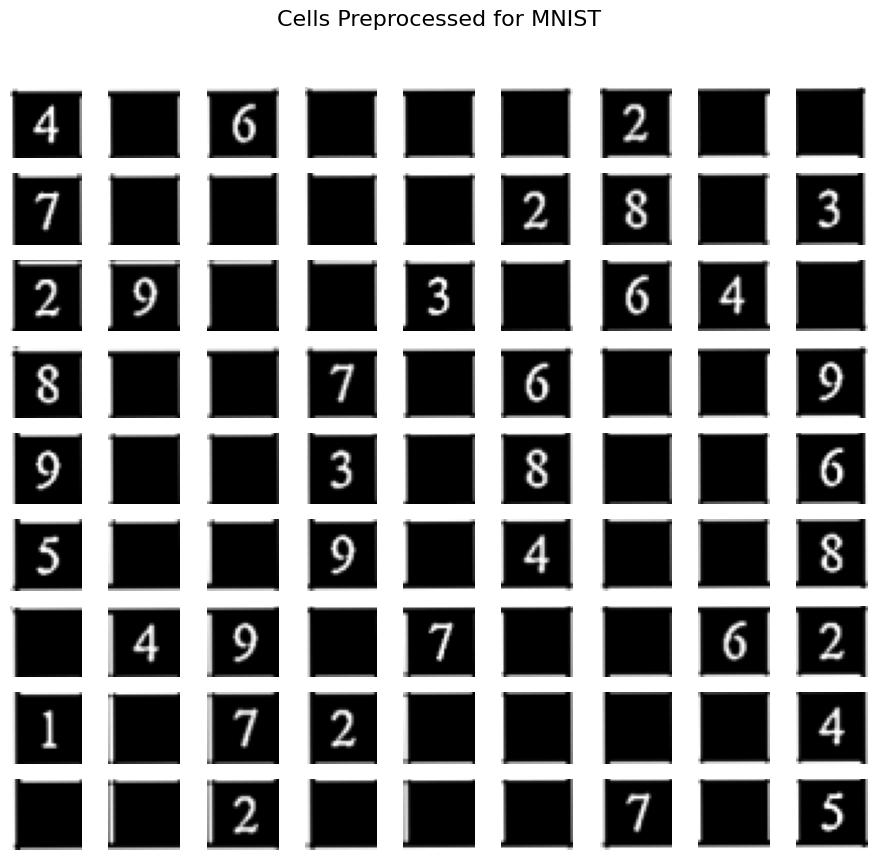

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [65]:
# Run the main program
if __name__ == "__main__":
    main()